In [1]:
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torchvision.transforms.functional as TF
import tifffile
import yaml
from einops import rearrange


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.registration.bigwarp import (
    read_bigwarp_warp_field, register_multiplex, register_visium, register_he, warp_image)
from mushroom.data.multiplex import extract_ome_tiff, write_basic_ome_tiff, get_ome_tiff_channels, make_pseudo
from mushroom.data.visium import adata_from_visium
from mushroom.visualization.utils import display_sections
import mushroom.utils as utils

In [5]:
run_dir = '/data/estorrs/mushroom/data/examples/HT397B1_v1'

In [6]:
metadata = yaml.safe_load(open(os.path.join(run_dir, 'registration', 'bigwarp', 'metadata.yaml')))
metadata

{'data': {'he': {'HT397B1-U1': '/data/spatial_transcriptomics/highres_images/breast/A1_HT397B1-S1H3A1U1.tif',
   'HT397B1-U21': '/data/spatial_transcriptomics/highres_images/breast/B1_HT397B1-S1H3A1U21.tif'},
  'multiplex': {'HT397B1-U12': '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
   'HT397B1-U2': '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
   'HT397B1-U22': '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff',
   'HT397B1-U31': '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff'},
  'visium': {'HT397B1-U1': '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U1/',
   'HT397B1-U21': '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U21/'}},
 'ids': ['s0', 's1', 's2', 's3', 's4', 's5'],
 'order': ['HT397

In [7]:
bigwarp_dir = os.path.join(run_dir, 'registration', 'bigwarp')
registered_dir = os.path.join(run_dir, 'registration', 'registered')
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [8]:
fps = sorted(utils.listfiles(bigwarp_dir, regex=r'ddf.tif$'))
fps

['/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/bigwarp/s1_ddf.tif',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/bigwarp/s2_ddf.tif',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/bigwarp/s3_ddf.tif',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/bigwarp/s4_ddf.tif',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/bigwarp/s5_ddf.tif']

In [9]:
section_to_ddf = {}
for fp in fps:
    sid = re.findall(r'(s[0-9])_ddf.tif', fp)[0]
    section_to_ddf[sid] = read_bigwarp_warp_field(fp, metadata['scale'])
section_to_ddf.keys(), next(iter(section_to_ddf.values())).shape

(dict_keys(['s1', 's2', 's3', 's4', 's5']), torch.Size([2, 18640, 18370]))

In [23]:
dtype, sample, fp = 'visium', 'HT397B1-U21', '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U21/'
sid = metadata['ids'][metadata['order'].index(sample)]
ddf = section_to_ddf.get(sid)
he = tifffile.imread(metadata['data']['he'][sample])
he = torch.tensor(rearrange(he, 'h w c -> c h w')) # channel dim must be first
adata = adata_from_visium(fp)
adata

/data/estorrs/miniconda3/envs/mushroom-dev/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom-dev/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2438 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [24]:
warped = warp_image(he, ddf)
warped.shape

torch.Size([3, 18640, 18370])

In [25]:
ddf.shape, he.shape

(torch.Size([2, 18640, 18370]), torch.Size([3, 18646, 18378]))

In [26]:
adata = register_visium(
    he, adata, ddf, target_pix_per_micron=metadata['registered_pixels_per_micron']
)

scale 0.9998259949828767
he warped torch.Size([3, 18640, 18370])
0.9998259949828767 (1999, 1970) (599, 591)


In [53]:
for dtype, mapping in metadata['data'].items():
    for sample, fp in mapping.items():
        print(dtype, sample, fp)
        sid = metadata['ids'][metadata['order'].index(sample)]
        ddf = section_to_ddf.get(sid)

        if dtype == 'he':
            he = tifffile.imread(fp)
            he = rearrange(he, 'h w c -> c h w') # channel dim must be first
            if ddf is not None:
                he = register_he(he, ddf)
            ppm = metadata['registered_pixels_per_micron']
            tifffile.imwrite(
                os.path.join(registered_dir, f'{sid}_he.tif'),
                data=rearrange(he, 'c h w -> h w c'),
                resolution=(ppm, ppm),
                compression='LZW',
                metadata={
                    'axes': 'YXC',
                    'unit': 'um',
                }
            )
        elif dtype == 'visium':
            # need unregistered full res H&E
            he = tifffile.imread(metadata['data']['he'][sample])
            he = rearrange(he, 'h w c -> c h w') # channel dim must be first
            adata = adata_from_visium(fp)
            if ddf is not None:
                adata = register_visium(
                    he, adata, ddf, target_pix_per_micron=metadata['registered_pixels_per_micron']
                )
            adata.write_h5ad(os.path.join(registered_dir, f'{sid}_visium.h5ad'))
        elif dtype == 'multiplex':
            channels, data = extract_ome_tiff(fp, as_dict=False)
            if ddf is not None:
                data = register_multiplex(data, ddf)
            write_basic_ome_tiff(
                os.path.join(registered_dir, f'{sid}_multiplex.ome.tiff'),
                data, channels, pix_per_micron=metadata['registered_pixels_per_micron']
            )

he HT397B1-U1 /data/spatial_transcriptomics/highres_images/breast/A1_HT397B1-S1H3A1U1.tif
he HT397B1-U21 /data/spatial_transcriptomics/highres_images/breast/B1_HT397B1-S1H3A1U21.tif
multiplex HT397B1-U12 /data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff
multiplex HT397B1-U2 /data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff
multiplex HT397B1-U22 /data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff
multiplex HT397B1-U31 /data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff
visium HT397B1-U1 /data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U1/
visium HT397B1-U21 /data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U21/


In [35]:
sorted(utils.listfiles(registered_dir))

['/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_he.tif',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_visium.h5ad',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s1_multiplex.ome.tiff',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s2_multiplex.h5ad',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s2_multiplex.ome.tiff',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_he.tif',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_visium.h5ad',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s4_multiplex.ome.tiff',
 '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s5_multiplex.ome.tiff']

In [7]:
config = [
    {
        'id': 's0', # identifier
        'position': 0, # section position (i.e. section number in z direction)
        'data': [ # data types and filepaths available for section
            {
                'dtype': 'he',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_he.tif'
            },
            {
                'dtype': 'visium',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s0_visium.h5ad'
            }
        ]
    },
    {
        'id': 's1',
        'position': 1,
        'data': [
            {
                'dtype': 'multiplex',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s1_multiplex.ome.tiff'
            }
        ]
    },
    {
        'id': 's2',
        'position': 11,
        'data': [
            {
                'dtype': 'multiplex',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s2_multiplex.ome.tiff'
            }
        ]
    },
    {
        'id': 's3',
        'position': 20,
        'data': [
            {
                'dtype': 'he',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_he.tif'
            },
            {
                'dtype': 'visium',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s3_visium.h5ad'
            }
        ]
    },
    {
    'id': 's4',
        'position': 21,
        'data': [
            {
                'dtype': 'multiplex',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s4_multiplex.ome.tiff'
            }
        ]
    },
    {
        'id': 's5',
        'position': 30,
        'data': [
            {
                'dtype': 'multiplex',
                'filepath': '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/s5_multiplex.ome.tiff'
            }
        ]
    },
]

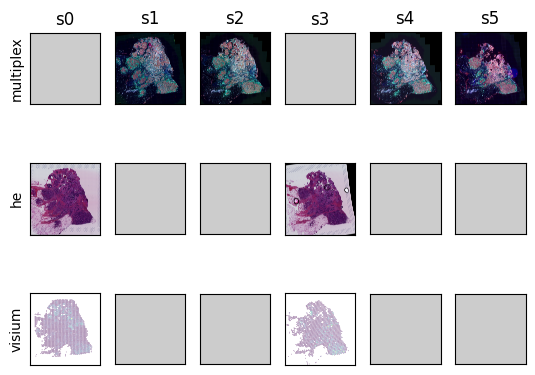

In [136]:
multiplex_cmap = {
    'DAPI': (0., 0., 1.),
    'Pan-Cytokeratin': (1., 0., 0.),
    'CD45 (D)': (0., 1., 0.),
    'SMA-(D)': (1., 1., 1.)
}

dtype_order = [
    'multiplex',
    'he',
    'visium'
]
display_experiment(config, multiplex_cmap=multiplex_cmap, dtype_order=dtype_order)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


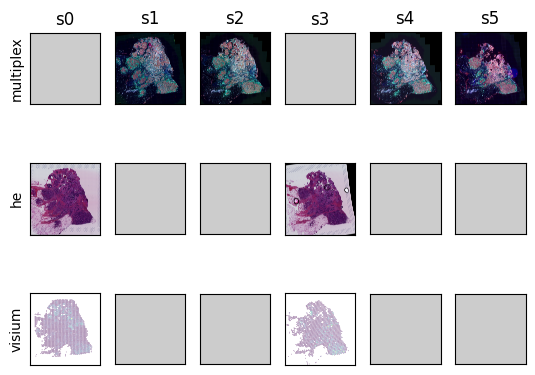

In [10]:
multiplex_cmap = {
    'DAPI': (0., 0., 1.),
    'Pan-Cytokeratin': (1., 0., 0.),
    'CD45 (D)': (0., 1., 0.),
    'SMA-(D)': (1., 1., 1.)
}

dtype_order = [
    'multiplex',
    'he',
    'visium'
]
display_sections(config, multiplex_cmap=multiplex_cmap, dtype_order=dtype_order)
plt.savefig('/data/estorrs/sandbox/HT397B1_serial.png', dpi=300)

In [138]:
yaml.safe_dump(config, open(os.path.join(registered_dir, 'mushroom_inputs.yaml'), 'w'))